## 공통 모듈 import 설정

In [ ]:
# 데이터 효율성 실험에 필요한 모듈과 공통 함수 불러오기
import torch                
import pandas as pd
import matplotlib.pyplot as plt
import os

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

import cifar_common
from cifar_common import (
    device,
    set_seed,
    create_cifar10_loaders,
    create_resnet18_cifar,
    create_vit_model,
    train_one_epoch,
    evaluate,
)

print("Using device:", device)
set_seed(42)


Using device: cuda


## 한 조건(model_type, data_ratio)에 대한 실험

In [ ]:
# 데이터 비율(data_ratio)을 인자로 받아 CNN/ViT 각각에 대해 같은 학습 설정으로 성능을 비교하기 위한 함수.

def run_experiment(
    model_type: str,
    data_ratio: float,
    num_epochs: int = 20,
    batch_size: int = 128,
    seed: int = 42,
):
    """
    한 조건에 대한 학습/평가.
    model_type: "cnn" 또는 "vit"
    data_ratio: 사용 train 비율 (1.0, 0.5, 0.2, 0.1 등)
    num_epochs: 학습 epoch 수
    """
    assert model_type in ["cnn", "vit"]

    set_seed(seed)  # 실험마다 난수를 고정해 data_ratio 변화만 비교

    if model_type == "cnn":
        for_vit = False
        loader_batch_size = batch_size
    else:
        for_vit = True
        loader_batch_size = min(batch_size, 64)  # ViT 메모리 고려

    # 데이터 비율에 맞춰 CIFAR-10 DataLoader 생성
    train_loader, test_loader = create_cifar10_loaders(
        data_ratio=data_ratio,
        for_vit=for_vit,
        batch_size=loader_batch_size,
    )

    # 모델 및 optimizer 설정 (CNN/ViT 별도 하이퍼파라미터)
    if model_type == "cnn":
        model = create_resnet18_cifar(num_classes=10, pretrained=False).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=5e-4,
        )
    else:
        if cifar_common.timm is None:
            raise RuntimeError("timm이 설치되어 있지 않아 ViT를 사용할 수 없습니다.")
        model = create_vit_model(
            model_name="vit_tiny_patch16_224",
            num_classes=10,
            pretrained=True,
        ).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=3e-4,
            weight_decay=0.05,
        )

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    best_test_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        # 동일 에폭 수만큼 학습/평가를 반복하며 성능 변화를 추적
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        test_loss, test_acc = evaluate(
            model, test_loader, criterion, device
        )

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc

        print(
            f"[{model_type.upper()}][ratio={data_ratio:.2f}][epoch={epoch}/{num_epochs}] "
            f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}"
        )

    print(
        f"\n[{model_type.upper()}] data_ratio={data_ratio:.2f}, "
        f"num_epochs={num_epochs} 기준 best test acc = {best_test_acc:.4f}\n"
    )

    return history, best_test_acc


## 여러 data_ratio에 대해 CNN / ViT 반복 실험 

In [ ]:
# 변경점: data_ratios 리스트를 돌면서 CNN / ViT 각각에 대해 같은 epoch 수로 실험을 반복하고 결과를 저장.
data_eff_root = "results/data_efficiency"
ensure_dir(f"{data_eff_root}/cnn")
ensure_dir(f"{data_eff_root}/vit")

# 적은 데이터에서 얼마나 버티는지 보기 위한 비율 리스트
data_ratios = [1.0, 0.5, 0.2, 0.1]
num_epochs = 20

results_summary = []

# CNN
for ratio in data_ratios:
    history_cnn, best_acc_cnn = run_experiment(
        model_type="cnn",
        data_ratio=ratio,
        num_epochs=num_epochs,
        batch_size=128,
        seed=42,
    )

    pd.DataFrame(history_cnn).to_csv(
        f"{data_eff_root}/cnn/cnn_ratio_{ratio:.2f}.csv", index=False
    )

    results_summary.append({
        "model": "cnn",
        "data_ratio": ratio,
        "best_test_acc": best_acc_cnn,
    })

# ViT
if cifar_common.timm is not None:
    for ratio in data_ratios:
        history_vit, best_acc_vit = run_experiment(
            model_type="vit",
            data_ratio=ratio,
            num_epochs=num_epochs,
            batch_size=128,
            seed=42,
        )

        pd.DataFrame(history_vit).to_csv(
            f"{data_eff_root}/vit/vit_ratio_{ratio:.2f}.csv", index=False
        )

        results_summary.append({
            "model": "vit",
            "data_ratio": ratio,
            "best_test_acc": best_acc_vit,
        })

# data_ratio 별 성능 비교 테이블
df_summary = pd.DataFrame(results_summary)
df_summary = df_summary.sort_values(by=["model", "data_ratio"]).reset_index(drop=True)
df_summary


======= CNN | data_ratio=1.00 =======
Files already downloaded and verified
Files already downloaded and verified
[CNN][ratio=1.00][epoch=1/20] train_acc=0.3871, test_acc=0.4969
[CNN][ratio=1.00][epoch=2/20] train_acc=0.5135, test_acc=0.5855
[CNN][ratio=1.00][epoch=3/20] train_acc=0.5822, test_acc=0.6349
[CNN][ratio=1.00][epoch=4/20] train_acc=0.6255, test_acc=0.6605
[CNN][ratio=1.00][epoch=5/20] train_acc=0.6591, test_acc=0.6853
[CNN][ratio=1.00][epoch=6/20] train_acc=0.6825, test_acc=0.6946
[CNN][ratio=1.00][epoch=7/20] train_acc=0.6973, test_acc=0.7178
[CNN][ratio=1.00][epoch=8/20] train_acc=0.7139, test_acc=0.7147
[CNN][ratio=1.00][epoch=9/20] train_acc=0.7239, test_acc=0.7185
[CNN][ratio=1.00][epoch=10/20] train_acc=0.7367, test_acc=0.7346
[CNN][ratio=1.00][epoch=11/20] train_acc=0.7473, test_acc=0.7456
[CNN][ratio=1.00][epoch=12/20] train_acc=0.7548, test_acc=0.7564
[CNN][ratio=1.00][epoch=13/20] train_acc=0.7646, test_acc=0.7613
[CNN][ratio=1.00][epoch=14/20] train_acc=0.7713, t

,model,data_ratio,num_epochs,best_test_acc
0,cnn,0.1,20,0.5144
1,cnn,0.2,20,0.6270
2,cnn,0.5,20,0.7310
3,cnn,1.0,20,0.7865
4,vit,0.1,20,0.8907
5,vit,0.2,20,0.9131
6,vit,0.5,20,0.9294
7,vit,1.0,20,0.9396


## data_ratio vs test accuracy 시각화

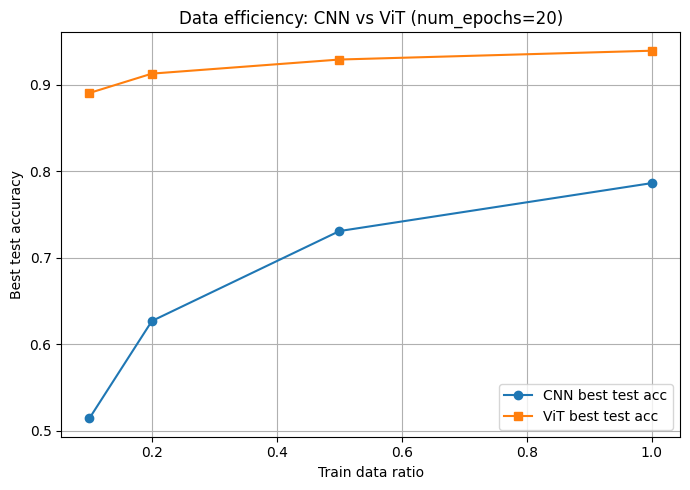

In [ ]:
# data_ratio에 따른 best test accuracy를 CNN / ViT 각각에 대해 한 그래프로 시각화함.

cnn_rows = df_summary[df_summary["model"] == "cnn"]
vit_rows = df_summary[df_summary["model"] == "vit"]

plt.figure(figsize=(7, 5))

plt.plot(
    cnn_rows["data_ratio"],
    cnn_rows["best_test_acc"],
    marker="o",
    label="CNN best test acc",
)

if not vit_rows.empty:
    plt.plot(
        vit_rows["data_ratio"],
        vit_rows["best_test_acc"],
        marker="s",
        label="ViT best test acc",
    )

plt.xlabel("Train data ratio")
plt.ylabel("Best test accuracy")
plt.title(f"Data efficiency: CNN vs ViT (num_epochs={num_epochs})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 수치 기반 비교

In [ ]:
# 보고서에서 바로 인용할 수 있도록 data_ratio별 CNN vs ViT 최종 성능을 텍스트로 정리.

print("데이터 비율에 따른 CNN vs ViT 최종 test accuracy 비교:\n")

for ratio in sorted(data_ratios, reverse=True):
    row_cnn = df_summary[(df_summary["model"] == "cnn") & (df_summary["data_ratio"] == ratio)]
    row_vit = df_summary[(df_summary["model"] == "vit") & (df_summary["data_ratio"] == ratio)]

    if not row_cnn.empty:
        cnn_acc = float(row_cnn["best_test_acc"].values[0])
    else:
        cnn_acc = None

    if not row_vit.empty:
        vit_acc = float(row_vit["best_test_acc"].values[0])
    else:
        vit_acc = None

    print(f"data_ratio = {ratio:.2f}")
    print(f"  CNN best test acc : {cnn_acc:.4f}" if cnn_acc is not None else "  CNN 결과 없음")
    print(f"  ViT best test acc : {vit_acc:.4f}" if vit_acc is not None else "  ViT 결과 없음")

    if cnn_acc is not None and vit_acc is not None:
        diff = vit_acc - cnn_acc
        print(f"  (ViT - CNN) 차이 : {diff:+.4f}")
    print()


데이터 비율에 따른 CNN vs ViT 최종 test accuracy 비교:

data_ratio = 1.00
  CNN best test acc : 0.7865
  ViT best test acc : 0.9396
  (ViT - CNN) 차이 : +0.1531

data_ratio = 0.50
  CNN best test acc : 0.7310
  ViT best test acc : 0.9294
  (ViT - CNN) 차이 : +0.1984

data_ratio = 0.20
  CNN best test acc : 0.6270
  ViT best test acc : 0.9131
  (ViT - CNN) 차이 : +0.2861

data_ratio = 0.10
  CNN best test acc : 0.5144
  ViT best test acc : 0.8907
  (ViT - CNN) 차이 : +0.3763

